In [12]:
import pandas as pd


In [13]:
pip install pandas

# ML

In [14]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

df_final_clean = pd.read_excel("df_final_clean.xlsx")
df_final_clean_encoded = df_final_clean.copy()

# ✅ 3. แปลง categorical เป็นตัวเลข (ถ้ามี)
for col in df_final_clean_encoded.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    df_final_clean_encoded[col] = le.fit_transform(df_final_clean_encoded[col]).astype(int)

df_final_clean_encoded = df_final_clean_encoded.drop(columns=['date'])
df_final_clean_encoded

,cases,temp_15d_avg,rain_15d_avg,humid_15d_avg,อายุ(ปี),เพศ,อาชีพ,ตำบล,อำเภอ,เดือน,ปี,ไตรมาส,ฤดูกาล
0,1,22.745000,0.000000,74.794444,34.0,0,0,8,1,2,2017,1,2
1,1,27.170000,2.386667,74.827333,13.0,0,10,60,8,4,2017,2,1
2,1,27.786667,2.520000,73.410667,51.0,1,0,60,8,5,2017,2,1
3,1,27.970000,4.253333,73.302667,14.0,1,10,60,8,5,2017,2,1
4,2,28.501333,4.233333,73.984667,58.0,0,9,60,8,5,2017,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,2,22.858571,2.071429,82.036429,20.5,1,6,3,2,12,2024,4,2
1046,2,22.716667,1.933333,81.784000,56.0,0,7,31,2,12,2024,4,2
1047,1,21.687333,1.933333,82.676000,11.0,1,10,15,2,12,2024,4,2
1048,1,21.304667,1.933333,82.992667,41.0,1,7,35,6,12,2024,4,2


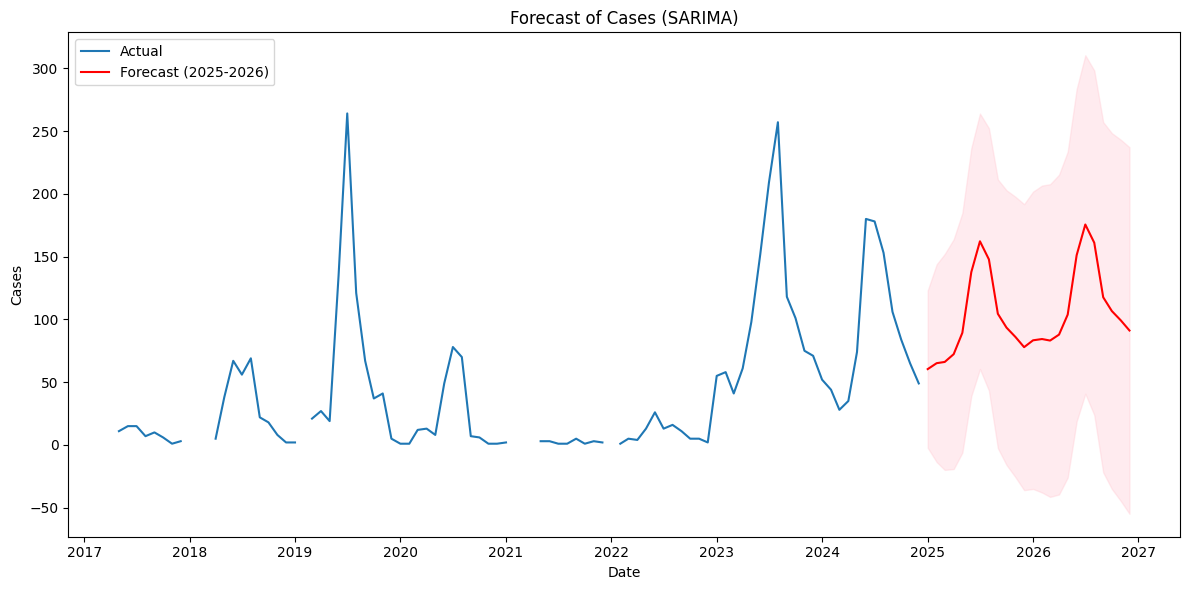

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# สร้าง datetime
df['ds'] = pd.to_datetime(df[['ปี', 'เดือน']].rename(columns={'ปี': 'year', 'เดือน': 'month'}).assign(day=1))

# รวมยอด cases ต่อเดือน
monthly_cases = df.groupby('ds')['cases'].sum().asfreq('MS')  # MS = Month Start

# แบ่ง train/test (optional)
train = monthly_cases[:'2024-12']
# test = monthly_cases['2025-01':]  # ถ้ามี

# สร้างโมเดล SARIMA
model = SARIMAX(train, 
                order=(1, 1, 1),           # p, d, q
                seasonal_order=(1, 1, 1, 12),  # P, D, Q, S (S=12 คือ season รายปี)
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# พยากรณ์ 24 เดือน (2 ปี)
forecast = results.get_forecast(steps=24)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_cases, label='Actual')
plt.plot(predicted_mean, label='Forecast (2025-2026)', color='red')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Forecast of Cases (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.tight_layout()
plt.show()

SARIMA model saved as 'sarima_model.pkl'


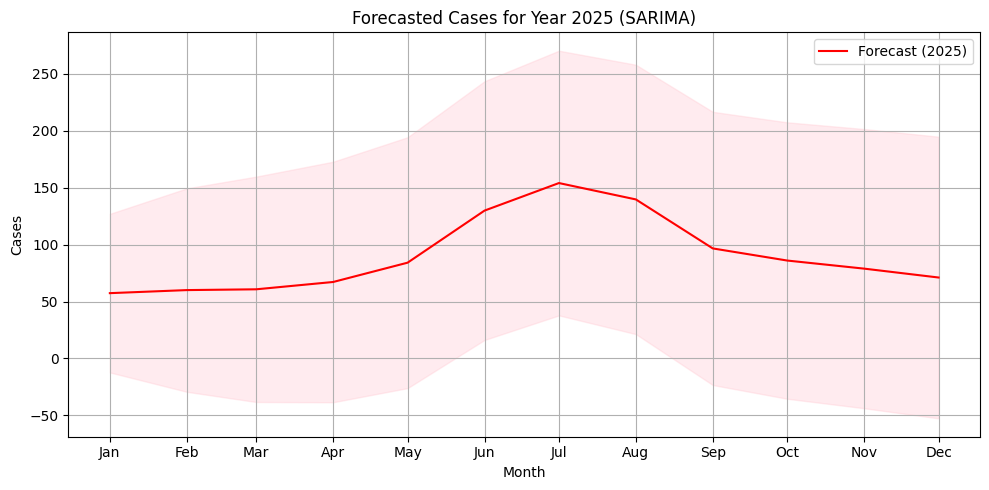

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# สร้าง datetime
df['ds'] = pd.to_datetime(df[['ปี', 'เดือน']].rename(columns={'ปี': 'year', 'เดือน': 'month'}).assign(day=1))

# รวมยอด cases ต่อเดือน
monthly_cases = df.groupby('ds')['cases'].sum().asfreq('MS')

# แบ่ง train
train = monthly_cases[:'2024-12']

# สร้างโมเดล SARIMA
model = SARIMAX(train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# บันทึกโมเดล SARIMA
results.save('sarima_model.pkl')
print("SARIMA model saved as 'sarima_model.pkl'")

# พยากรณ์ 24 เดือน
forecast = results.get_forecast(steps=24)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# เลือกเฉพาะปี 2025
pred_2025 = predicted_mean['2025-01':'2025-12']
conf_2025 = conf_int.loc['2025-01':'2025-12']

# Plot เฉพาะปี 2025
plt.figure(figsize=(10, 5))
plt.plot(pred_2025.index, pred_2025, label='Forecast (2025)', color='red')
plt.fill_between(pred_2025.index,
                 conf_2025.iloc[:, 0],
                 conf_2025.iloc[:, 1], color='pink', alpha=0.3)

# ตกแต่งกราฟ
plt.title('Forecasted Cases for Year 2025 (SARIMA)')
plt.xlabel('Month')
plt.ylabel('Cases')
plt.xticks(pred_2025.index, [d.strftime('%b') for d in pred_2025.index])  # ชื่อเดือนแบบ Jan, Feb, ...
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# โหลดโมเดลที่บันทึกไว้
results = SARIMAXResults.load('sarima_model.pkl')

# ใช้โมเดลพยากรณ์ได้เลย
forecast = results.get_forecast(steps=12)
print(forecast.predicted_mean)


2025-01-01     57.356048
2025-02-01     60.040841
2025-03-01     60.735230
2025-04-01     67.167764
2025-05-01     84.127711
2025-06-01    129.872085
2025-07-01    154.083446
2025-08-01    139.698726
2025-09-01     96.652722
2025-10-01     86.003350
2025-11-01     78.895129
2025-12-01     71.092921
Freq: MS, Name: predicted_mean, dtype: float64


In [9]:
df_final_clean_encoded.corr()['cases']

cases            1.000000
temp_15d_avg     0.100030
rain_15d_avg     0.094145
humid_15d_avg    0.018460
อายุ(ปี)        -0.034136
เพศ              0.007874
อาชีพ            0.088724
ตำบล             0.051749
อำเภอ            0.042857
เดือน           -0.005328
ปี               0.229528
ไตรมาส           0.013666
ฤดูกาล          -0.147233
Name: cases, dtype: float64

✅ RMSE: 0.39
✅ R²: 0.986


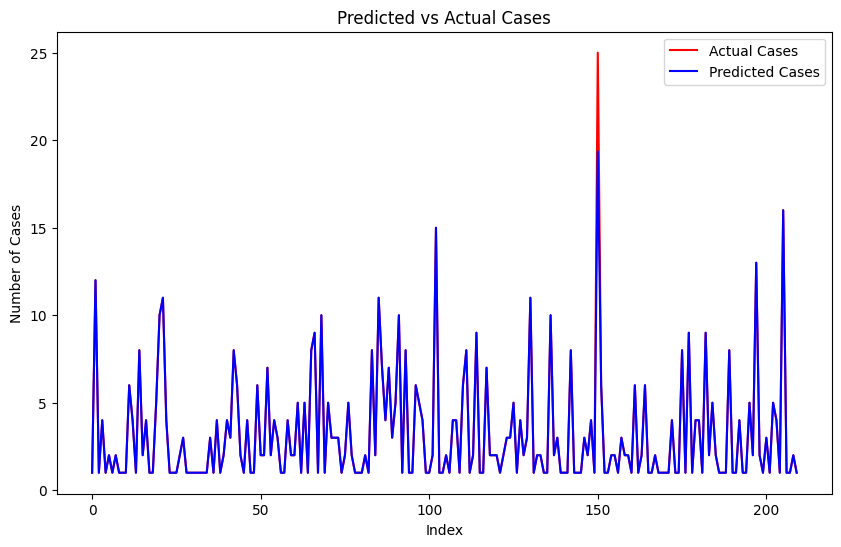

In [29]:

# ✅ 4. กำหนด X และ y
X = df_final_clean_encoded.drop(columns=['เพศ','เดือน','อายุ(ปี)','ไตรมาส','humid_15d_avg'])
y = df_final_clean['cases']

# ✅ 5. แบ่งชุด train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ 6. สร้างโมเดล Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# ✅ 7. ฝึกโมเดล
gb_model.fit(X_train, y_train)

# ✅ 8. ทำนายผล
y_pred = gb_model.predict(X_test)

# ✅ 9. ประเมินผล
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R²: {r2:.3f}")

# ✅ 10. วาดกราฟเปรียบเทียบค่าทำนาย vs ค่าจริง
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual Cases', color='red')
plt.plot(y_pred, label='Predicted Cases', color='blue')
plt.title('Predicted vs Actual Cases')
plt.xlabel('Index')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()


In [10]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib

# ------------------ โหลดข้อมูล ------------------
df = pd.read_excel("df_final_clean.xlsx")

# ลบช่องว่างชื่อคอลัมน์
df.columns = df.columns.str.strip()

# แปลงวันที่
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# ------------------ สร้าง lag features ------------------
# cases[t-1], cases[t-2], cases[t-3]
df['lag1'] = df['cases'].shift(1)
df['lag2'] = df['cases'].shift(2)
df['lag3'] = df['cases'].shift(3)

# rolling average
df['roll3'] = df['cases'].shift(1).rolling(3).mean()
df['roll6'] = df['cases'].shift(1).rolling(6).mean()

# ------------------ season feature ------------------
def month_to_season(m):
    if m in [3,4,5]:
        return "ร้อน"
    elif m in [6,7,8,9]:
        return "ฝน"
    else:
        return "หนาว"

df['season'] = df['month'].apply(month_to_season)

# ------------------ ลบ missing จากการ shift ------------------
df = df.dropna()

# ------------------ Feature / Target ------------------
features = ['lag1','lag2','lag3','roll3','roll6','month','year']
X = df[features]
y = df['cases']

# ------------------ Train/Test split ------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=12)

# ------------------ Train XGBoost ------------------
model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# ------------------ Evaluate ------------------
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# ------------------ Save Model ------------------
joblib.dump(model, "xgb_forecast_model.pkl")
print("✅ XGBoost forecast model saved as xgb_forecast_model.pkl")

# ------------------ ทำนายเดือนถัดไป ------------------
latest = df.iloc[-1]   # แถวล่าสุด
next_input = pd.DataFrame([{
    "lag1": latest['cases'],
    "lag2": df.iloc[-2]['cases'],
    "lag3": df.iloc[-3]['cases'],
    "roll3": df['cases'].iloc[-3:].mean(),
    "roll6": df['cases'].iloc[-6:].mean(),
    "month": (latest['month'] % 12) + 1,
    "year": latest['year'] + (1 if latest['month']==12 else 0)
}])

next_pred = model.predict(next_input)[0]
print(f"📌 ทำนายจำนวนผู้ป่วยเดือนถัดไป ({int(next_input['year'])}-{int(next_input['month']):02d}) = {int(round(next_pred))} คน")


RMSE: 2.4392771966686158
✅ XGBoost forecast model saved as xgb_forecast_model.pkl
📌 ทำนายจำนวนผู้ป่วยเดือนถัดไป (2025-01) = 1 คน


C:\Users\USER\AppData\Local\Temp\ipykernel_5540\3983374011.py:84: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f"📌 ทำนายจำนวนผู้ป่วยเดือนถัดไป ({int(next_input['year'])}-{int(next_input['month']):02d}) = {int(round(next_pred))} คน")


✅ XGBoost RMSE: 0.08
✅ XGBoost R²: 0.999
✅ XGBoost MAE: 0.01


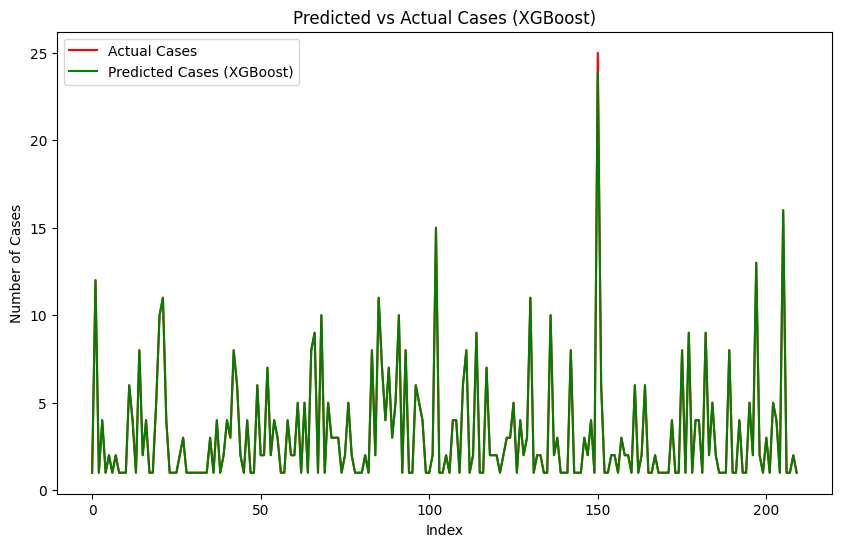

In [31]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# ✅ 4. กำหนด X และ y
X = df_final_clean_encoded.drop(columns=['เพศ','เดือน','อายุ(ปี)','ไตรมาส','humid_15d_avg'])
y = df_final_clean['cases']

# ✅ 5. แบ่งชุด train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ 6. สร้างโมเดล XGBoost
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# ✅ 7. ฝึกโมเดล
xgb_model.fit(X_train, y_train)

# ✅ 8. ทำนายผล
y_pred = xgb_model.predict(X_test)

# ✅ 9. ประเมินผล
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)  # คำนวณ MAE

print(f"✅ XGBoost RMSE: {rmse:.2f}")
print(f"✅ XGBoost R²: {r2:.3f}")
print(f"✅ XGBoost MAE: {mae:.2f}")  # แสดงผล MAE

# ✅ 10. วาดกราฟเปรียบเทียบค่าทำนาย vs ค่าจริง
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual Cases', color='red')
plt.plot(y_pred, label='Predicted Cases (XGBoost)', color='green')
plt.title('Predicted vs Actual Cases (XGBoost)')
plt.xlabel('Index')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()


In [32]:
X

,cases,temp_15d_avg,rain_15d_avg,อาชีพ,ตำบล,อำเภอ,ปี,ฤดูกาล
0,1,22.745000,0.000000,0,8,1,2017,2
1,1,27.170000,2.386667,10,60,8,2017,1
2,1,27.786667,2.520000,0,60,8,2017,1
3,1,27.970000,4.253333,10,60,8,2017,1
4,2,28.501333,4.233333,9,60,8,2017,1
...,...,...,...,...,...,...,...,...
1045,2,22.858571,2.071429,6,3,2,2024,2
1046,2,22.716667,1.933333,7,31,2,2024,2
1047,1,21.687333,1.933333,10,15,2,2024,2
1048,1,21.304667,1.933333,7,35,6,2024,2


In [33]:
import joblib

# บันทึกโมเดลที่ฝึกเสร็จแล้ว
joblib.dump(xgb_model, 'xgb_model.pkl')


['xgb_model.pkl']

🔎 Overfitting Check
Train RMSE: 0.00
Train R²: 1.000
Test  RMSE: 0.08
Test  R²: 0.999


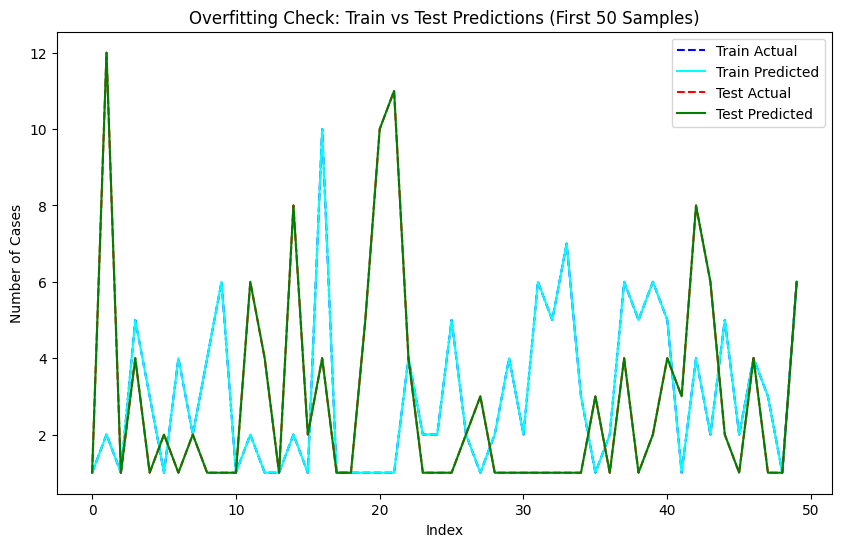

In [21]:
# ✅ ประเมินผล Train set
y_train_pred = xgb_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

print("🔎 Overfitting Check")
print(f"Train RMSE: {rmse_train:.2f}")
print(f"Train R²: {r2_train:.3f}")
print(f"Test  RMSE: {rmse:.2f}")
print(f"Test  R²: {r2:.3f}")

# ✅ วาดกราฟเปรียบเทียบ Train vs Test
plt.figure(figsize=(10,6))
plt.plot(y_train.values[:50], label='Train Actual', color='blue', linestyle='--')
plt.plot(y_train_pred[:50], label='Train Predicted', color='cyan')
plt.plot(y_test.values[:50], label='Test Actual', color='red', linestyle='--')
plt.plot(y_pred[:50], label='Test Predicted', color='green')
plt.title('Overfitting Check: Train vs Test Predictions (First 50 Samples)')
plt.xlabel('Index')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()


✅ XGBoost RMSE: 0.08
✅ XGBoost R²: 0.999
📊 Cross-validated R² (mean): 0.997
📊 Cross-validated R² (std): 0.004


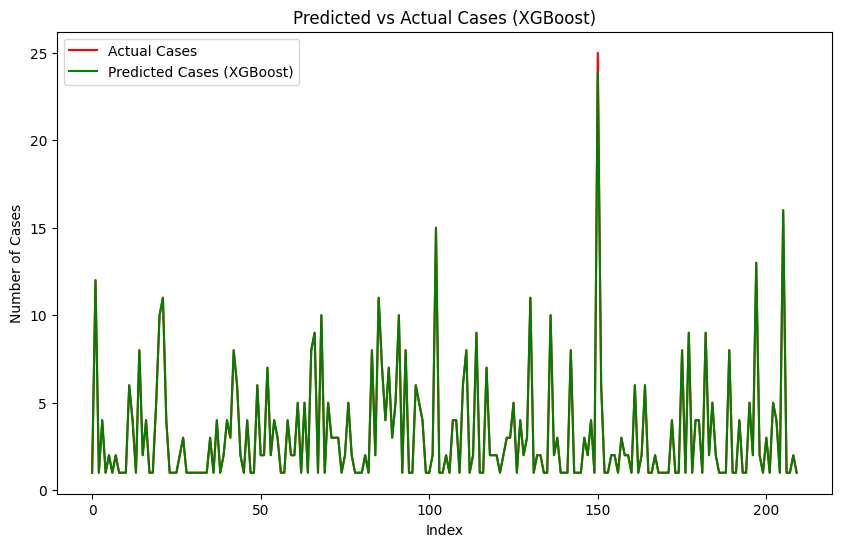

In [22]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# ✅ 1. กำหนด X และ y (ตัดตัวแปรที่ไม่จำเป็นออก)
X = df_final_clean_encoded.drop(columns=['เพศ','เดือน','อายุ(ปี)','ไตรมาส','humid_15d_avg'])
y = df_final_clean['cases']

# ✅ 2. แบ่งชุด train/test (ใหม่)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ 3. สร้างและฝึกโมเดล XGBoost
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# ✅ 4. ทำนายผล
y_pred = xgb_model.predict(X_test)

# ✅ 5. ประเมินผล
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"✅ XGBoost RMSE: {rmse:.2f}")
print(f"✅ XGBoost R²: {r2:.3f}")

# ✅ 6. ตรวจสอบ Cross-validation R²
cv_r2_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')
print(f"📊 Cross-validated R² (mean): {cv_r2_scores.mean():.3f}")
print(f"📊 Cross-validated R² (std): {cv_r2_scores.std():.3f}")

# ✅ 7. วาดกราฟเปรียบเทียบค่าทำนาย vs ค่าจริง
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual Cases', color='red')
plt.plot(y_pred, label='Predicted Cases (XGBoost)', color='green')
plt.title('Predicted vs Actual Cases (XGBoost)')
plt.xlabel('Index')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()


✅ Random Forest RMSE: 0.39
✅ Random Forest R²: 0.986


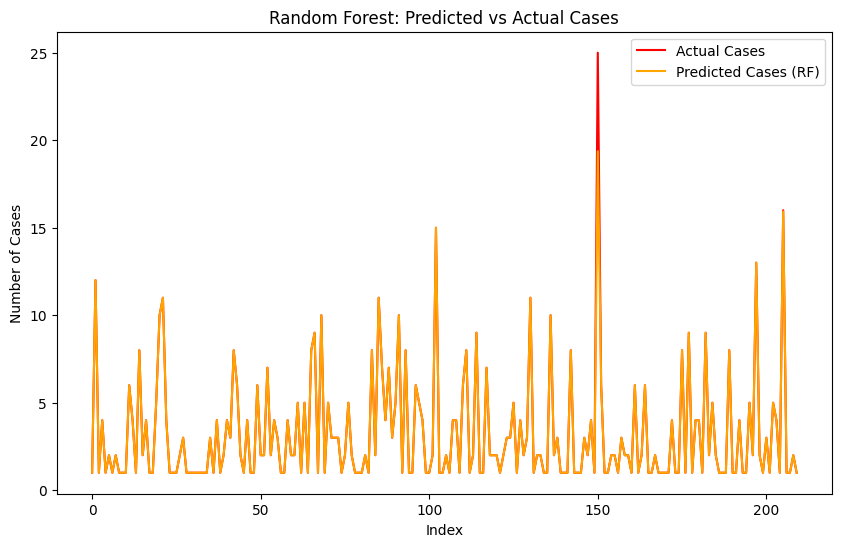

In [23]:
from sklearn.ensemble import RandomForestRegressor
X = df_final_clean_encoded.drop(columns=['เพศ','เดือน','อายุ(ปี)','ไตรมาส','humid_15d_avg'])
y = df_final_clean['cases']

# ✅ 6. สร้างโมเดล Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    random_state=42
)

# ✅ 7. ฝึกโมเดล
rf_model.fit(X_train, y_train)

# ✅ 8. ทำนายผล
y_pred = rf_model.predict(X_test)

# ✅ 9. ประเมินผล
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"✅ Random Forest RMSE: {rmse:.2f}")
print(f"✅ Random Forest R²: {r2:.3f}")

# ✅ 10. วาดกราฟเปรียบเทียบค่าทำนาย vs ค่าจริง
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual Cases', color='red')
plt.plot(y_pred, label='Predicted Cases (RF)', color='orange')
plt.title('Random Forest: Predicted vs Actual Cases')
plt.xlabel('Index')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()


📊 Comparison of Models (RMSE & MAE):
               Model  RMSE   MAE
0  Gradient Boosting  0.39  0.03
1            XGBoost  0.08  0.01
2      Random Forest  0.39  0.03
3      Deep Learning  0.13  0.10


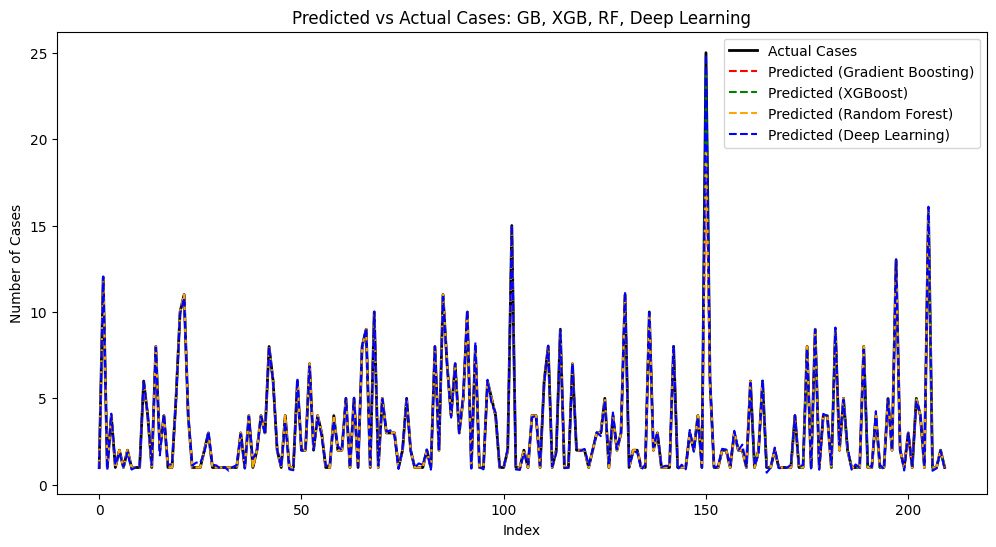

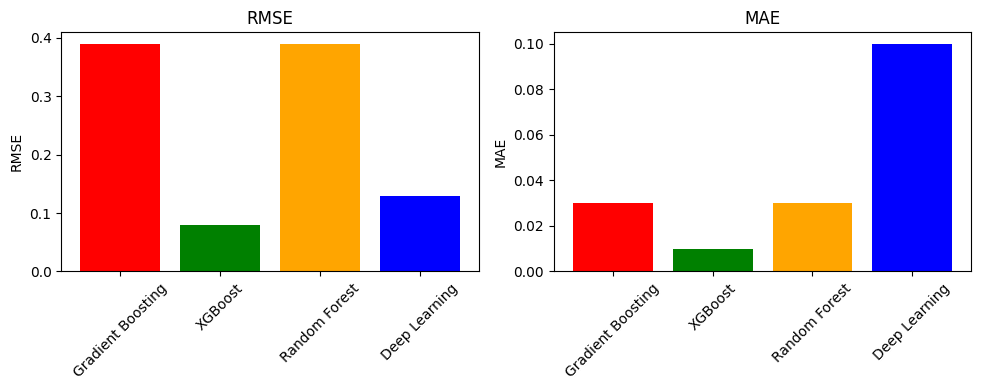

In [24]:
# ==========================
# 0. Import Libraries
# ==========================
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==========================
# 1. กำหนด X และ y
# ==========================
X = df_final_clean_encoded.drop(columns=['เพศ','เดือน','อายุ(ปี)','ไตรมาส','humid_15d_avg'])
y = df_final_clean['cases']

# ==========================
# 2. แบ่งชุด train/test
# ==========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================
# 3. Standardize สำหรับ Deep Learning
# ==========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================
# 4. โมเดล Gradient Boosting
# ==========================
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# ==========================
# 5. โมเดล XGBoost
# ==========================
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# ==========================
# 6. โมเดล Random Forest
# ==========================
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# ==========================
# 7. โมเดล Deep Learning (MLP)
# ==========================
dl_model = MLPRegressor(hidden_layer_sizes=(64,32), activation='relu', solver='adam',
                        max_iter=500, random_state=42)
dl_model.fit(X_train_scaled, y_train)
y_pred_dl = dl_model.predict(X_test_scaled)

# ==========================
# 8. ประเมินผล RMSE & MAE
# ==========================
models = ['Gradient Boosting', 'XGBoost', 'Random Forest', 'Deep Learning']
preds = [y_pred_gb, y_pred_xgb, y_pred_rf, y_pred_dl]

metrics = []
for name, y_pred in zip(models, preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    metrics.append({'Model': name, 'RMSE': round(rmse,2), 'MAE': round(mae,2)})

metrics_df = pd.DataFrame(metrics)
print("📊 Comparison of Models (RMSE & MAE):")
print(metrics_df)

# ==========================
# 9. กราฟ Actual vs Predicted
# ==========================
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual Cases', color='black', linewidth=2)
plt.plot(y_pred_gb, label='Predicted (Gradient Boosting)', color='red', linestyle='--')
plt.plot(y_pred_xgb, label='Predicted (XGBoost)', color='green', linestyle='--')
plt.plot(y_pred_rf, label='Predicted (Random Forest)', color='orange', linestyle='--')
plt.plot(y_pred_dl, label='Predicted (Deep Learning)', color='blue', linestyle='--')
plt.title('Predicted vs Actual Cases: GB, XGB, RF, Deep Learning')
plt.xlabel('Index')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()

# ==========================
# 10. Bar chart RMSE & MAE
# ==========================
plt.figure(figsize=(10,4))
metrics_list = ['RMSE','MAE']
colors = ['red','green','orange','blue']

for i, metric in enumerate(metrics_list):
    plt.subplot(1,2,i+1)
    plt.bar(metrics_df['Model'], metrics_df[metric], color=colors)
    plt.title(metric)
    plt.ylabel(metric)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [37]:
import joblib

model = joblib.load('xgb_model.pkl')
print(model.feature_names_in_)


['cases' 'temp_15d_avg' 'rain_15d_avg' 'อาชีพ' 'ตำบล' 'อำเภอ' 'ปี'
 'ฤดูกาล']
